## Fisher Information Matrix

The Fisher information matrix can be defined as $F_{ij}[h] = (h_{i}, h_{j})$ where $h_{i}$ is the partial derivative of $h(f)$ with respect to the i-th parameter $\theta_{i}$ and "( , )" denotes an inner product weighted by the expected PSD of detector noise, such as:

$$
(h, g) = 4 \cdot Re[\int_{0}^{\infty} \frac{h(f)^{*}g(f)}  {S_{n}(f)} df].
$$

The Fisher matrix can also be represented as 

$$
F_{ij} = \langle \partial_{i} \log p(s | \theta_{0}), \partial_{j} \log p(s | \theta_{0}) \rangle_{n},
$$
which, under certain conditions, is equivalent to

$$
F_{ij} = -\langle \partial_{i} \partial_{j} \log p(s | \theta_{0}) \rangle_{n}.
$$

We represent an average over the probability distribution of noise as "$\langle \cdot \rangle_{n}$", and

$$
\langle u(s), v(s)\rangle_{n} = \int u(s) v(s) p(s | \theta_{0}) ds.
$$

For a posterior $p(\theta_{0} | s)$ sufficiently close to the true source parameter $\theta_{0}$, under the assumption of Gaussian noise and in the high SNR limit, the inverse of the Fisher matrix can be interpreted as the covariance matrix for the posterior probability distribution.


Adapted (a.k.a. occasionally taken word-for-word) from https://arxiv.org/pdf/gr-qc/0703086v2.pdf

In [1]:
from __future__ import division

import numpy
import lal
import lalsimulation
from lalinference.rapid_pe import lalsimutils
import matplotlib.pyplot as plt


In [52]:
def generate_waveform(m_chirp, eta):
    """
    Generate a generic TaylorF2 waveform given a chirp mass and symmetric mass ratio
    using a TaylorF2 appriximation for binaries with zero spin.
    
    m_chirp -- chirp mass 
    
    eta -- symmetric mass ratio
    
    Returns:
    h1 -- magnitude of h_plus and h_cross in the frequency domain
    """
    
    # Generate a waveform following the same procedure in waveform_overlap.ipynb
    m1, m2 = lalsimutils.m1m2(m_chirp, eta)
    s1x, s1y, s1z = 0.0, 0.0, 0.0
    s2x, s2y, s2z = 0.0, 0.0, 0.0
    coa_phase, polarization_angle = 0.0, 0.0
    ra, dec = 0.0, 0.0
    dist, incl = 1e6 * lal.PC_SI, 0.0
    flow = 30
    fmax = 2048
    delta_f = 0.125
    approx1 = lalsimulation.IMRPhenomPv2  #TaylorF2

    hpf, hxf = lalsimulation.SimInspiralFD(coa_phase, delta_f,
                                m1, m2,
                                s1x, s1y, s1z,
                                s2x, s2y, s2z,
                                flow, fmax, flow,
                                dist, 0.0, incl,
                                0.0, 0.0, None, None,
                                0, -1, approx1)

    # For convenience, we'll reuse hpf and redefine to be h1
    hpf.data.data += hxf.data.data
    h1 = hpf
    return h1.data.data

In [53]:
# Assign necessary variables and define the overlap object

# Bounds of the integral -- we consider anything outside of these bounds to be effectively zero because of the
# waveform terminating or the detector sensitivity being too small
flow = 30
fmax = fnyq = 2048

# We're actually doing a numerical integral so df -> \delta f
delta_f = 0.125

# Define the overlap object
olap = lalsimutils.Overlap(flow, fmax, fnyq, delta_f)



In [136]:
# Pick a constant eta
eta = 0.2

# Iterate over a set of different chirp masses and calculate h(f) for each chirp mass
delta_mc = 1  # Solar masses
mcs = numpy.arange(1, 40, delta_mc)
#delta_mc *= lal.MSUN_SI  # Convert to proper units
waveforms = []
waveform_data = []
for mc in mcs:
    waveforms.append(generate_waveform(mc, eta))
waveforms = numpy.asarray(waveforms)


## Calculate $\frac{\partial h(f)}{\partial M_{c}}$

I have now generated an h(f) for several different values of $M_{c}$.

For each h(f), I will calculate $\frac{\partial h(M_{i}, f_{j})}{\partial M_{c}}$ numerically, at each value of $f$, by the following equation

$$
\frac{\partial h(M_{i}, f_{j})}{\partial M_{c}} = \frac{h(M_{i+1}, f_{j}) - h(M_{i}, f_{j})}{\Delta M_{c}},
$$
for each chirp mass i, at each frequency j.

In [137]:
waveform_derivs = []
# Iterate over each M_chirp and get the waveform (h(f)) at each M_chirp
for waveform_index in numpy.arange(len(waveforms) - 1):
    waveform_deriv = []
    waveform = waveforms[waveform_index]
    
    # Find the h(f_index) for the next chirp mass value
    #next_waveform = waveforms[waveform_index + 1]
    mc_close = mcs[waveform_index] + 0.001  # Make calculations at a very close value of M_chirp
    waveform_close = generate_waveform(mc_close, eta)
    
    
    # For a given h(f) iterate over each frequency value and calculate derivative
    for freq_index, freq in enumerate(waveform):
        waveform_deriv.append((waveform_close[freq_index] - waveform[freq_index]) / delta_mc)
    waveform_derivs.append(numpy.asarray(waveform_deriv))
waveform_derivs = numpy.asarray(waveform_derivs)

  

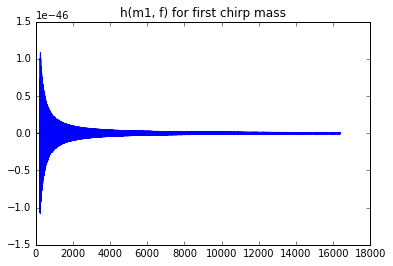

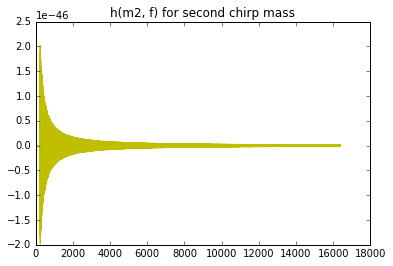

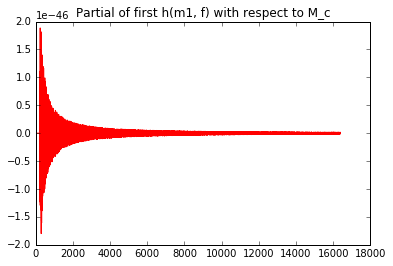

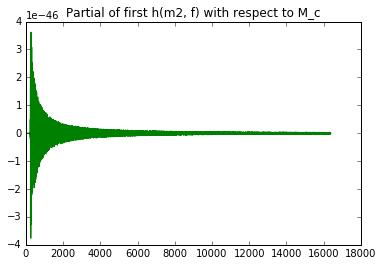

In [138]:
# Plot some stuff

plt.figure(1)
plt.plot(waveforms[0], 'b')
plt.title('h(m1, f) for first chirp mass')

plt.figure(2)
plt.plot(waveforms[1], 'y')
plt.title('h(m2, f) for second chirp mass')

plt.figure(3)
plt.plot(waveform_derivs[0], 'r')
plt.title('Partial of first h(m1, f) with respect to M_c')

plt.figure(4)
plt.plot(waveform_derivs[1], 'g')
plt.title('Partial of first h(m2, f) with respect to M_c')
plt.show()

In [151]:
# Get a PSD to weight the Fisher matrix
frequencies, psd = numpy.loadtxt("H1-GDS-CALIB_STRAIN.txt", unpack=True)
df = frequencies[1] - frequencies[0]  
psd = psd**2

# Make a dictionary giving the psd value for a given frequency
psd_dict = {}
for index, freq in enumerate(frequencies):
    psd_dict[freq] = psd[index]


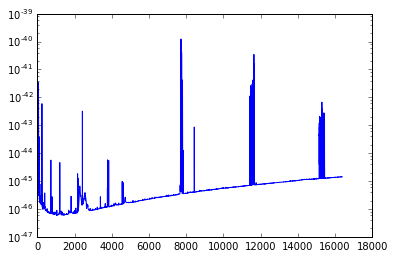

In [152]:
# Select only the relevant frequencies
psd_relevant = []
# FIX ME: there has to be an easier way to extract the frequency values from SimInspiralFD
for index in numpy.arange(len(waveforms[0])):
    freq = flow + delta_f*index
    psd_relevant.append(psd_dict[freq])
psd_relevant = numpy.asarray(psd_relevant)

plt.semilogy(psd_relevant)
plt.show()

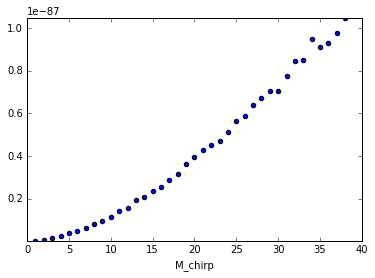

In [153]:
# Calculate the Fisher matrix for each m_chirp without psd
fisher = []
for deriv in waveform_derivs:
    fisher.append(4 * numpy.real(numpy.sum(deriv * deriv.conj() ) * delta_f))
    

plt.scatter(mcs[:-1], numpy.asarray(fisher))
plt.xlim([0, None])
plt.ylim(min(fisher), max(fisher))
plt.xlabel('M_chirp')
plt.show()

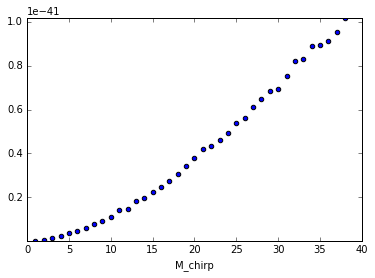

In [154]:
# Calculate the Fisher matrix for each m_chirp with psd
fisher = []
for deriv in waveform_derivs:
    fisher.append(4 * numpy.real(numpy.sum(deriv * numpy.conjugate(deriv) / psd_relevant ) * delta_f))
plt.scatter(mcs[:-1], numpy.asarray(fisher))
plt.xlim([0, None])
plt.ylim(min(fisher), max(fisher))
plt.xlabel('M_chirp')
plt.show()

In [112]:
d = waveform_derivs[5]
print(mcs[5])
print(psd_relevant[300])
print(d[300])
print(numpy.conjugate(d[300]))
print(d[300] * numpy.conjugate(d[300]))
print(d[300] * numpy.conjugate(d[300]) / psd_relevant[300])

6
1.04728513189e-23
(-7.66161625546e-46-1.82601586052e-46j)
(-7.66161625546e-46+1.82601586052e-46j)
(6.20346975687e-91+0j)
(5.92338186419e-68+0j)


In [116]:
print(d)
print(d * numpy.conjugate(d))
print(d[-2] * numpy.conjugate(d[-2]))

[  0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j
   0.00000000e+00 +0.00000000e+00j ...,   1.81966065e-48 -4.28994797e-48j
  -5.96239170e-48 +2.07063531e-48j   0.00000000e+00 +0.00000000e+00j]
[  0.00000000e+00+0.j   0.00000000e+00+0.j   0.00000000e+00+0.j ...,
   2.17148184e-95+0.j   3.98376454e-95+0.j   0.00000000e+00+0.j]
(3.98376453772e-95+0j)
